In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from functools import partial
# from funcy import compose
compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from numpy.fft import fft, ifft, fftfreq

from best_subset import *
from solvel0 import solvel0
from UBIC import fit_blr, UBIC, decreasing_values_indices
from para_UBIC import *

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.random import sample_without_replacement
# https://github.com/Pongpisit-Thanasutives/OKRidge
from okridge.solvel0 import okridge_solvel0, okridge_solvel0_full
from findiff import FinDiff

import getpass
import sys; sys.path.append(f'/Users/{getpass.getuser()}/Documents/github/ICOMP/')
from icomp_lm import *

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs, epsilon=1e-5):
    nobs2 = nobs / 2.0
    # llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    llf = -nobs2*np.log(2*np.pi*ssr/nobs+epsilon)
    return llf

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    # llf = ssr2llf(rss, nobs, epsilon)
    # return -2*llf + np.log(nobs)*nparams
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord='fro')**2 
    # llf = -(N/2)*np.log(2*np.pi*rss/N+epsilon)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # return -2*llf + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)
fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.5.1


In [2]:
def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return np.array(Theta_grouped), np.array(Ut_grouped)

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    normalized_As = As.copy()
    normalized_bs = bs.copy()
    # normalize
    for i in range(m):
        normalized_As[i] = normalized_As[i].dot(np.diag(candidate_norms**-1))
        normalized_bs[i] = normalized_bs[i]/norm_bs[i]
        
    return normalized_As, normalized_bs

def remove_f(uu, percent):
    if percent <= 0: return uu
    PSD = (uu*np.conj(uu))/np.prod(uu.shape)
    PSD = PSD.real
    mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
    return uu*mask

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

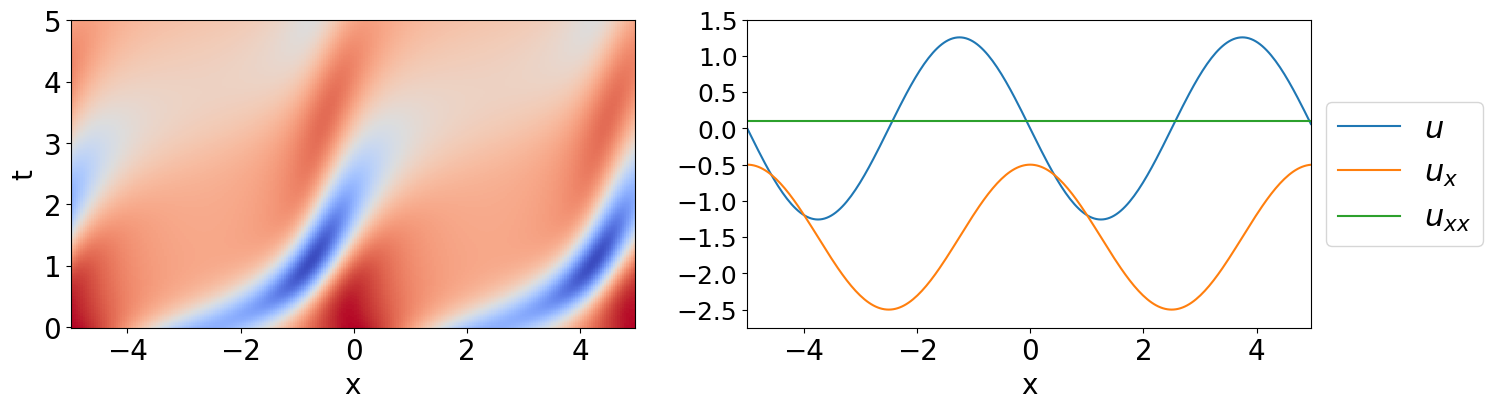

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
show()
# fig.tight_layout()

In [5]:
noise_lv = 4 # 2, 4
noise_lv = abs(noise_lv)
u_clean = u.copy()
u = u + 0.01*noise_lv*std(u)*np.random.randn(*u.shape)

In [6]:
is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    # equivalent to np.hstack([savgol_filter(u[:, i], window_size, poly_order).reshape(-1, 1) for i in range(u.shape[-1])])
    u = savgol_filter(u, window_size, poly_order, axis=0)

In [7]:
# Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, 
#                                          time_diff = 'FD', space_diff = 'Fourier')
alpha = 3e-4 # 1e-3 (ok for pysr env. but not ok for pysindy_latest env.)
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                        diff_kwargs, 
                                                                        include_bias=False)
# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "spatial")

fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

# physics is such fundamental that it can be discovered from in low-freq data (validation set)
# fft_percent = 90
# acc = 8
# d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(u)
# d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(u)
# d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(u)
# d_dt = FinDiff(1, dt, 1, acc=acc); u_t = d_dt(u)
    
# phi1 = [u**i for i in range(0, 4)]; phi1_names = ["", "u", "u^{2}", "u^{3}"]
# phi2 = [u_x, u_xx, u_xxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}"]
# phi = phi1.copy(); phi_names = phi1_names.copy()
# phi.extend([p1*p2 for p1 in phi1 for p2 in phi2])
# phi = np.array(phi)
# phi_names.extend([p1+p2 for p1 in phi1_names for p2 in phi2_names])
# fft_phi = [remove_f(fft(_), fft_percent) for _ in phi]
# fft_u_t = remove_f(fft(u_t), fft_percent)

# Theta_grouped = np.moveaxis(phi, 0, -1)
# Ut_grouped = np.expand_dims(u_t, -1)
# rhs_des = phi_names
# fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
# fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

# del phi1, phi2, phi1_names, phi2_names

0 u
3 u_x
4 u_xx
5 u_xxx


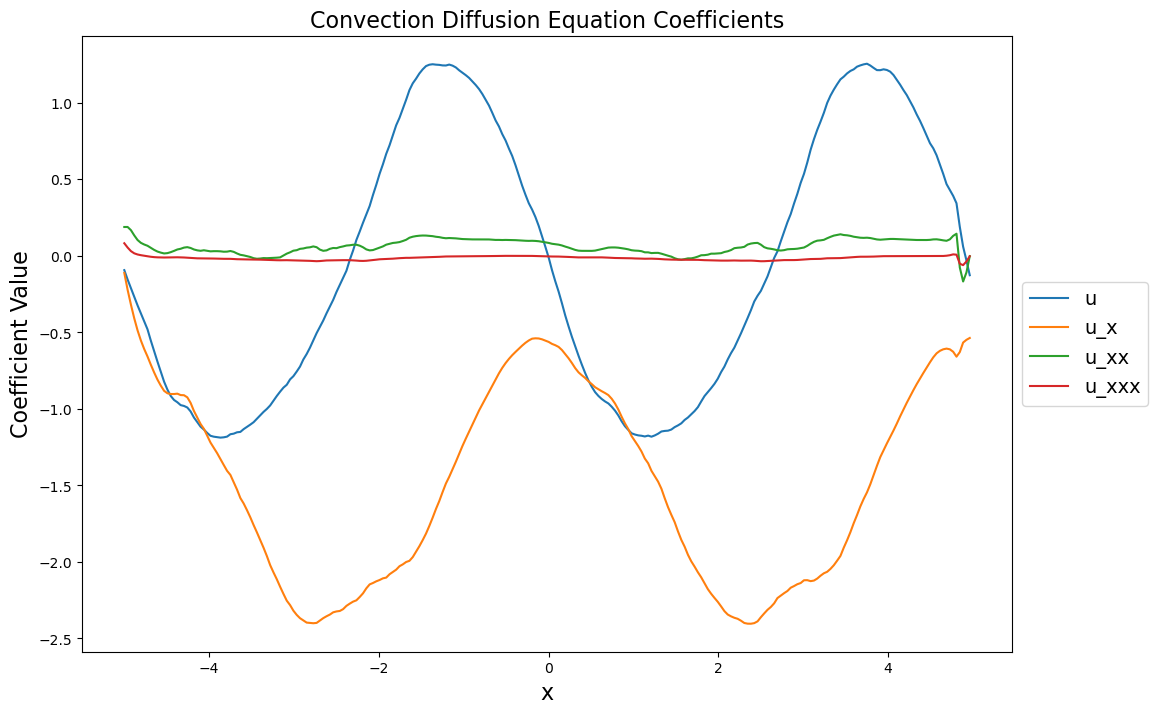

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [9]:
true_xi = np.vstack((u_true, u_x_true, u_xx_true))
errors = xi[[0, 3, 4]]-true_xi
errors = 100*np.linalg.norm(errors, axis=1)/np.linalg.norm(true_xi, axis=1)
errors.mean(), errors.std()

(26.594728832214802, 24.58938318449823)

In [10]:
# candidates = set()
# # max_complexity=X_weak.shape[-1]
# max_complexity = 10
# for i in trange(len(Theta_grouped)):
#     candidates = candidates.union(set(solvel0(Theta_grouped[i], Ut_grouped[i], 
#                                               max_complexity=max_complexity, 
#                                               miosr=True, refine=True, verbose=False)))
# candidates

candidates = set()
max_complexity = 10 # X_weak.shape[-1]
counter = set(); i = 0
max_counter = 30 # 30
while True:
    bs_i = []
    
    bs_i = solvel0(Theta_grouped[i], Ut_grouped[i], max_complexity=max_complexity, 
                   miosr=True, refine=True, verbose=False)
    
#     bs_i = solvel0(normalized_Theta_grouped[i], 
#                    normalized_Ut_grouped[i], 
#                    max_complexity=max_complexity, 
#                    miosr=True, refine=True, verbose=False)
    
#     bs_i = best_subset_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
#     bs_i = abess_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
#     try:  _, bs_i = okridge_solvel0_full(Theta_grouped[i], Ut_grouped[i], k=max_complexity)
#     except AttributeError: pass
    
    if len(bs_i) > 0:
        bs_i = list(map(tuple, bs_i))
        candidates = candidates.union(bs_i)
        counter.add(i)
        
    if len(counter) == max_counter: break        
    # print(len(counter))
    
    i = np.random.choice(len(Theta_grouped))
    while i in counter:
        i = np.random.choice(len(Theta_grouped))

candidates

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-17


{(0, 1, 2, 3, 4, 5, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7, 11),
 (0, 1, 2, 3, 4, 5, 6, 7, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 12, 16),
 (0, 1, 2, 3, 4, 5, 6, 7, 15),
 (0, 1, 2, 3, 4, 5, 6, 7, 15, 16),
 (0, 1, 2, 3, 4, 5, 6, 7, 16),
 (0, 1, 2, 3, 4, 5, 6, 16),
 (0, 1, 2, 3, 4, 5, 7, 9, 16),
 (0, 1, 2, 3, 4, 5, 11, 15),
 (0, 1, 2, 3, 4, 6, 7, 8, 10, 16),
 (0, 1, 2, 3, 5, 6, 8, 11, 13),
 (0, 1, 2, 3, 5, 6, 8, 11, 13, 18),
 (0, 1, 2, 3, 5, 6, 11, 13),
 (0, 1, 2, 3, 5, 7, 8, 11),
 (0, 1, 2, 3, 5, 7, 8, 11, 13),
 (0, 1, 2, 3, 5, 7, 8, 11, 13, 17),
 (0, 1, 2, 3, 5, 7, 8, 11, 16, 18),
 (0, 1, 2, 3, 5, 7, 11),
 (0, 1, 2, 3, 5, 7, 11, 16, 17, 18),
 (0, 1, 2, 3, 5, 7, 11, 16, 18),
 (0, 1, 2, 3, 5, 7, 11, 18),
 (0, 1, 2, 3, 5, 8, 10, 11, 12, 15),
 (0, 1, 2, 3, 5, 8, 10, 11, 15),
 (0, 1, 2, 3, 5, 11, 12, 14, 15, 17),
 (0, 1, 2, 3, 5, 15, 16, 17, 18),
 (0, 1, 2, 3, 5, 15, 16, 18),
 (0, 1, 2, 3, 15, 16, 18),
 (0, 1, 3, 4, 5, 6, 7),
 (0, 1, 3, 4, 5, 6, 7, 8, 10, 11),
 (0, 1, 3, 4, 5, 6, 7, 8, 12, 18),
 (0, 1, 3,

In [11]:
lam = 0 # use regtools matlab ดีไหม?
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print("lam:", lam)

track = {}
for indices in tqdm(candidates):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        ridge_model = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        est_xi = ridge_model.coef_.reshape(-1, 1)
        # difference = Ut_grouped[j] - ridge_model.predict(Theta_grouped[j][:, indices])
        # rss += np.linalg.norm(difference, 2)**2
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
        
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss
        
candidates = set([e[0] for e in list(track.values())])
candidates

lam: 0.08581588470365772


100%|██████████████████████████████████████████████████████████████████| 168/168 [00:10<00:00, 15.52it/s]


{(0, 1, 2, 3, 4, 5, 7, 9, 16),
 (0, 1, 3, 4, 5, 6, 7, 8, 10, 11),
 (0, 1, 3, 4, 5, 6, 7, 11),
 (0, 2, 3, 4, 5, 7, 9),
 (0, 3),
 (0, 3, 4),
 (0, 3, 4, 6, 7),
 (0, 3, 4, 6, 7, 13),
 (0, 3, 4, 7),
 (3,)}

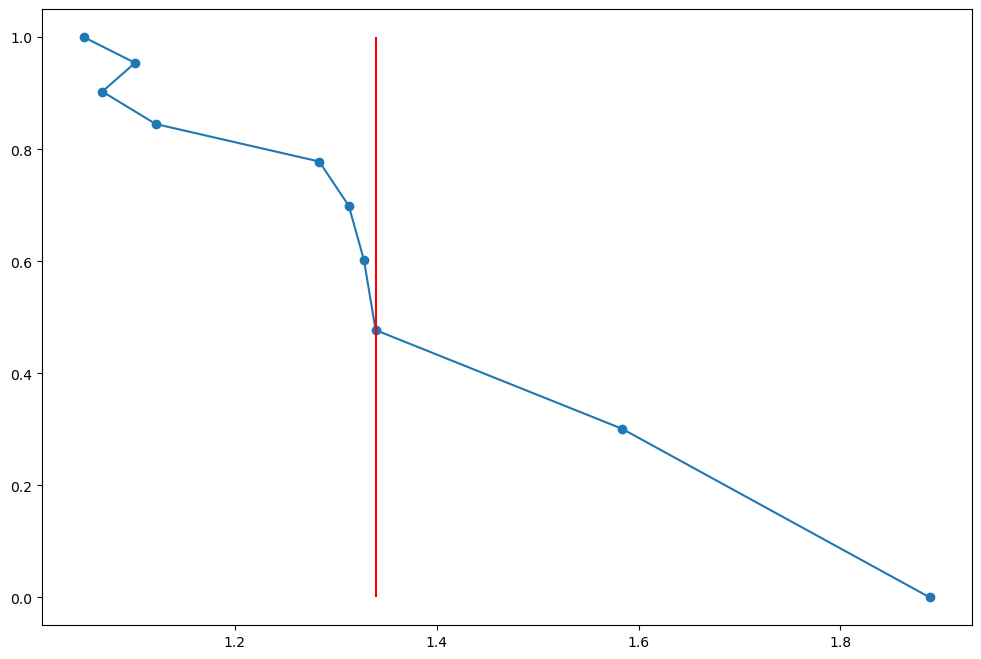

In [12]:
log_errors = []
log_coms = []
for indices in sorted(candidates, key=len):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = SkLinearRegression(fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = Ut_grouped[j] - Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.sum(difference**2)
    log_error = np.log10(np.sqrt(rss))
    log_com = np.log10(com)
    log_errors.append(log_error)
    log_coms.append(log_com)
plt.plot(log_errors, log_coms, '-o')
plt.vlines(find_corner(log_errors, log_coms), ymin=min(log_coms), ymax=max(log_coms), color='red')
plt.show()

10 3
10 3


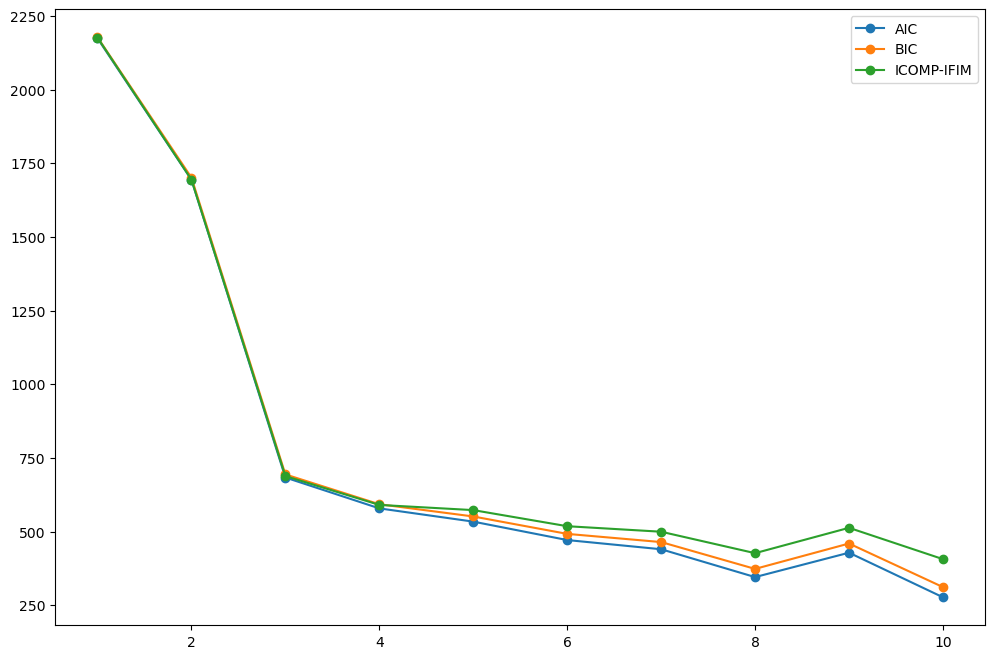

In [13]:
# from scipy import linalg as splinalg
# from scipy.sparse import csc_array, csc_matrix
# from scipy.sparse import linalg as splin

# for indices in sorted(candidates, key=len):
#     theta_b = csc_matrix(splinalg.block_diag(*[Theta_grouped[j][:, indices] for j in range(len(Theta_grouped))]), dtype=float)
#     ut_b = Ut_grouped.reshape(-1, 1)
#     xi_b = splin.lsqr(theta_b, ut_b)[0].reshape(-1, 1)
#     rss = np.sum((ut_b-theta_b@xi_b)**2)
#     print(len(indices), rss2bic(rss, np.count_nonzero(xi_b), len(ut_b)))
#     break

time_integrator = lambda _: _
time_integrator = partial(trapz, axis=1)
time_integrator = compose(time_integrator, 
                          lambda _ : periodogram(_, return_onesided=False, axis=1)[1])
ic_scores = {}
ICOMPs = []
for indices in sorted(candidates, key=len):
    CMs = []
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
        _, CM, _ = llf_complexity(Theta_grouped[j][:, indices], Ut_grouped[j], a_n=np.log(len(Ut_grouped[j])))
        CMs.append(CM[2])
    
    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    # N = np.prod(Ut_grouped.shape)
    N = np.prod(time_integrator(Ut_grouped).shape)
    # k = len(np.where(np.linalg.norm(est_xi, axis=-1)>0)[0])
    k = len(indices)
    # k = k*est_xi.shape[-1]
    
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    # bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    aic = N*np.log(2*np.pi*rss/N+1e-5) + 2*k+(2*k**2+2*k)/(N-k-1)
    bic = N*np.log(2*np.pi*rss/N+1e-5) + np.log(N)*k
    icomp = N*np.log(2*np.pi*rss/N+1e-5) + np.log(N)*np.mean(CMs)
    ICOMPs.append(icomp)
    
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]
print(complexities[np.argmin(aics)], find_corner(complexities, aics))
print(complexities[np.argmin(bics)], find_corner(complexities, bics))
plt.plot(complexities, aics, '-o', label='AIC')
plt.plot(complexities, bics, '-o', label='BIC')
plt.plot(complexities, ICOMPs, '-o', label='ICOMP-IFIM')
plt.legend()
plt.show()

In [14]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):        
        # model = Ridge(alpha=lam, fit_intercept=False)
        # model = BayesianRidge(fit_intercept=False)
        model = ARDRegression(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction)**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)

100%|████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 1546.86it/s]


In [15]:
min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
complexities = sorted(best_subsets.keys())
uncertainties = []
for com in complexities:
    _, uncert, _ = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
uncertainties = np.array(uncertainties)

nfft = None; return_onesided = False
# ground_periogram = periodogram(ifft(fft_Ut_grouped[:, :, 0]), nfft=nfft)[-1]
ground_periogram = periodogram(Ut_grouped, axis=1, return_onesided=return_onesided)[1][:, :, 0]

10 3


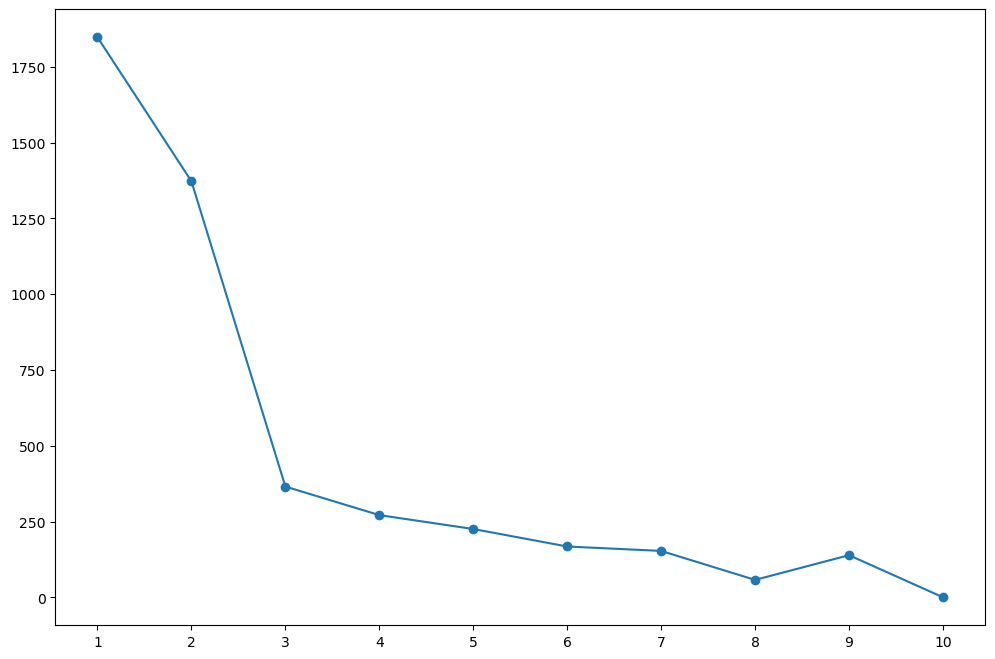

In [16]:
nfft = None
epsilon = 1e-5
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=1) # min_{axis} rss_list
threshold_lambda = 1e6
ics = []
rss_list = []
for com in complexities:
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
#         est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
        ARD = ARDRegression(threshold_lambda=threshold_lambda, fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                                        Ut_grouped[j].flatten())
        assert com == np.count_nonzero(ARD.coef_)
        est_xi[eff_indices, j:j+1] = ARD.coef_.reshape(-1, 1)

#         post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
#         post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
#         ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(post_prediction.T, return_onesided=return_onesided)[1]
        ground = periodogram(Ut_grouped[j].T, return_onesided=return_onesided)[1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))
        
    # pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    # pred_periogram = periodogram(pred_group, nfft=nfft)[-1]
    pred_group = prediction_group(Theta_grouped, est_xi)
    pred_periogram = periodogram(pred_group, axis=1, return_onesided=return_onesided)[1]
    diff_periogram = time_integrator(ground_periogram)-time_integrator(pred_periogram)
    res = np.vstack([diff_periogram[j] for j in range(len(diff_periogram))])
    nobs = np.prod(diff_periogram.shape)
    rss = np.linalg.norm(res, ord='fro')**2
    ics.append(nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*com)
    rss_list.append(rss)

print(np.argmin(ics)+1, find_corner(complexities, ics))
plt.plot(complexities, ics-min(ics), '-o')
plt.xticks(complexities)
plt.show()

In [17]:
varying_bics = []
pvalues = []
for eff_indices in sorted(candidates, key=len):
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    com = len(eff_indices)
    for j in range(len(Theta_grouped)):
#         est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
        ARD = ARDRegression(threshold_lambda=threshold_lambda, fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                                        Ut_grouped[j].flatten())
        assert com == np.count_nonzero(ARD.coef_)
        est_xi[eff_indices, j:j+1] = ARD.coef_.reshape(-1, 1)

#         post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
#         post_prediction = periodogram(ifft(post_prediction.flatten()))[1]
#         ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[1]
        post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(post_prediction.T, return_onesided=return_onesided)[1]
        ground = periodogram(Ut_grouped[j].T, return_onesided=return_onesided)[1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        # vbics.append(rss2bic(rss, com+uncertainties[com-1], len(post_prediction), epsilon))
        vbics.append(rss2bic(rss, com, len(post_prediction), epsilon))
        
    pvalue = np.nan
    if len(varying_bics) > 0 and not np.allclose(vbics, varying_bics[-1]):
        # wres = wilcoxon(vbics, varying_bics[-1], alternative='less')
        wres = mannwhitneyu(vbics, varying_bics[-1], alternative='less')
        pvalue = wres.pvalue
        pvalues.append(pvalue)
    varying_bics.append(vbics)
        
    print(eff_indices, pvalue)

varying_bics = np.array(varying_bics); test_size = varying_bics.shape[1]
varying_bics = varying_bics-varying_bics.min()
varying_bics_ranking = np.argsort(varying_bics.sum(axis=-1))
varying_bics = varying_bics[:, sample_without_replacement(varying_bics.shape[1], 
                                                          test_size, 
                                                          random_state=42)]

valid_indices = []
min_bic = np.inf
j = None
pcut = 0.01
pvalues = np.array(pvalues)
# pcut = np.percentile(pvalues[(0 < pvalues) & (pvalues < pcut)], 90); print(pcut)
pcut = np.median(pvalues[(0 < pvalues) & (pvalues < pcut)]); print(pcut)
for i, pvalue in enumerate(pvalues):
    if ics[i] < min_bic:
        min_bic = ics[i]
        if i == 0: pvalue = 0.0
        else: 
            # pvalue = wilcoxon(varying_bics[i]-varying_bics[j], alternative='less').pvalue
            pvalue = mannwhitneyu(varying_bics[i], varying_bics[j], alternative='less').pvalue
        if pvalue <= pcut:
            valid_indices.append(i)
        j = i
valid_indices

(3,) nan
(0, 3) 2.099748019140494e-15
(0, 3, 4) 3.04523249560079e-28
(0, 3, 4, 7) 0.9575834407860085
(0, 3, 4, 6, 7) 0.7553847077039728
(0, 3, 4, 6, 7, 13) 0.2215972028155221
(0, 2, 3, 4, 5, 7, 9) 4.739081662160061e-16
(0, 1, 3, 4, 5, 6, 7, 11) 0.0043193159364516565
(0, 1, 2, 3, 4, 5, 7, 9, 16) 0.9432788759284643
(0, 1, 3, 4, 5, 6, 7, 8, 10, 11) 0.03076423932824018
1.28682809267825e-15


[0, 2, 6]

In [18]:
def conditional_argmin(ics, valid_indices=None):
    am = np.argmin(ics)
    if valid_indices is None:
        return am
    else:
        assert len(valid_indices) > 0 and len(set(valid_indices)-set(np.arange(len(ics)))) == 0
        # return valid_indices[np.argmin(abs(valid_indices-np.argmin(ics)))] # (ALSO WORKS)
        # return max(valid_indices[np.where(valid_indices<=np.argmin(ics))[0]])
        for idx in np.argsort(ics):
            if idx in valid_indices and idx <= am: return idx
valid_indices = np.array(valid_indices) # None

verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    _, _, indices = best_subsets[com]
    rss = rss_list[com-1]
    assert com == len(indices)
    lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
assert np.allclose(np.array(ics), np.array(b_bics))
print(find_corner(complexities, b_bics))

idx2lambda =  d = dict([(_-1, []) for _ in complexities])
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = conditional_argmin(last_ubic, valid_indices)
idx2lambda[np.argmin(last_ubic)].append(last_lam)

thres = 1e-4
percent = 75 # 75 # 90 (เพราะไม่เอา complexity = 1)
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))
print("Threshold:", thres)
print("P-value threshold:", pcut)

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = conditional_argmin(now_ubic, valid_indices)
    idx2lambda[np.argmin(now_ubic)].append(now_lam)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    diff_vbic = (varying_bics[now_bc]-varying_bics[last_bc])
    
    diff_vbic_adj = np.array([-np.inf for _ in range(1000)])
    adj_bc = varying_bics_ranking[varying_bics_ranking<now_bc]
    if len(adj_bc) > 0:
        adj_bc = adj_bc[0]
        diff_adj = now_bc-adj_bc
        diff_vbic_adj = varying_bics[now_bc]-varying_bics[adj_bc]

    imp = np.nan
    pvalue_pos = pvalue_neg = pvalue_adj = np.nan
    if np.abs(diff_com) > 0:
        # imp < thres <--> pvalue > pcut
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    if not np.allclose(diff_vbic, 0.0):
        pvalue_pos = wilcoxon(diff_vbic, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_vbic, alternative='less').pvalue
    if np.abs(diff_adj) > 0:
        pvalue_adj = wilcoxon(diff_vbic_adj, alternative='less').pvalue

    ### new version using wilcoxon test ###
#     if verbose:
#         print(last_bc, '--->', adj_bc, '--->', now_bc, 'p-value:', 
#               np.nan_to_num(pvalue_pos, nan=np.inf), 
#               np.nan_to_num(pvalue_neg, nan=np.inf), 
#               np.nan_to_num(pvalue_adj, nan=np.inf))
#     if (diff_com > 0 and (diff_bic > 0 or pvalue_pos > pcut or pvalue_adj > pcut)) or \
#         (diff_com < 0 and diff_bic > 0 and pvalue_pos > pcut and pvalue_neg <= pcut):
#         break

    ### old version using threshold ###
        if verbose:
            print(last_bc, '--->', now_bc, 'imp:', np.nan_to_num(imp, nan=np.inf))
        if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp > thres):
            break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)
    
last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
lam_plot = min(idx2lambda[last_bc])
ubic_plot = UBIC(b_bics, uncertainties, nobs, hyp=10**lam_plot)
lam_plot, last_lam, last_ubic, last_bc

3
Threshold: 0.20209502184681868
P-value threshold: 1.28682809267825e-15
2 ---> 2 imp: inf
2 ---> 6 imp: 0.07605037966946887
(0, 3, 4) selected


(1.6548457379289565,
 1.65484574,
 array([2593.65367483, 1956.04119768,  952.40808033, 1055.15806832,
        1009.37136253,  958.41601838, 1046.10008004, 1084.42928361,
        1323.51963074, 1084.63503853]),
 2)

3


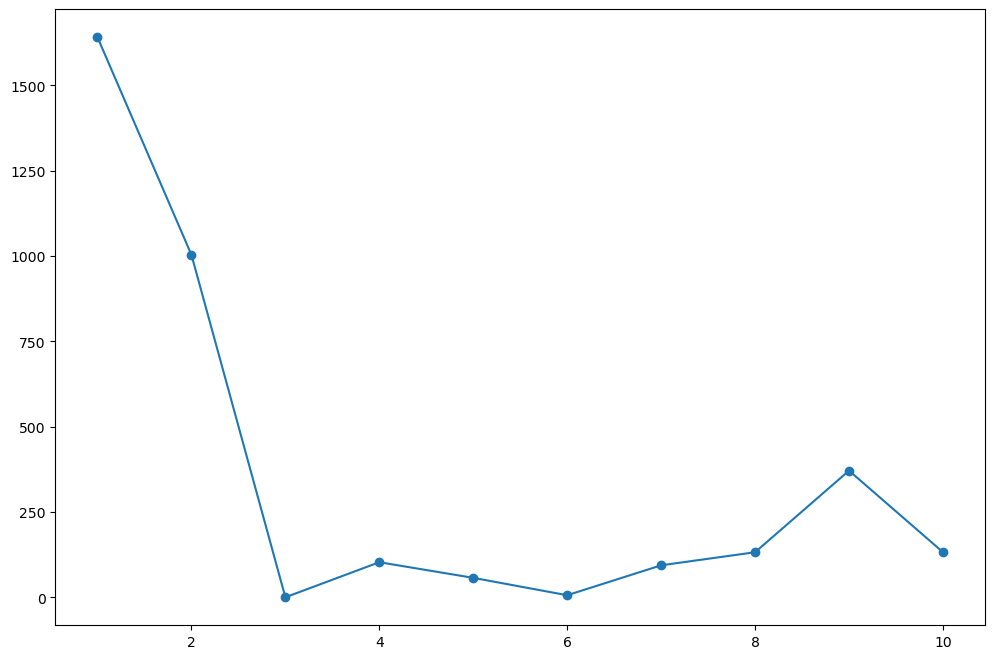

In [19]:
print(np.argmin(ubic_plot)+1)
plt.plot(complexities, ubic_plot-min(ubic_plot), '-o'); plt.show()

[1.64821113 1.         1.01497348 1.8013472  1.80153473 1.8286648
 2.23698378 2.77174328 3.40077821 3.00164584]


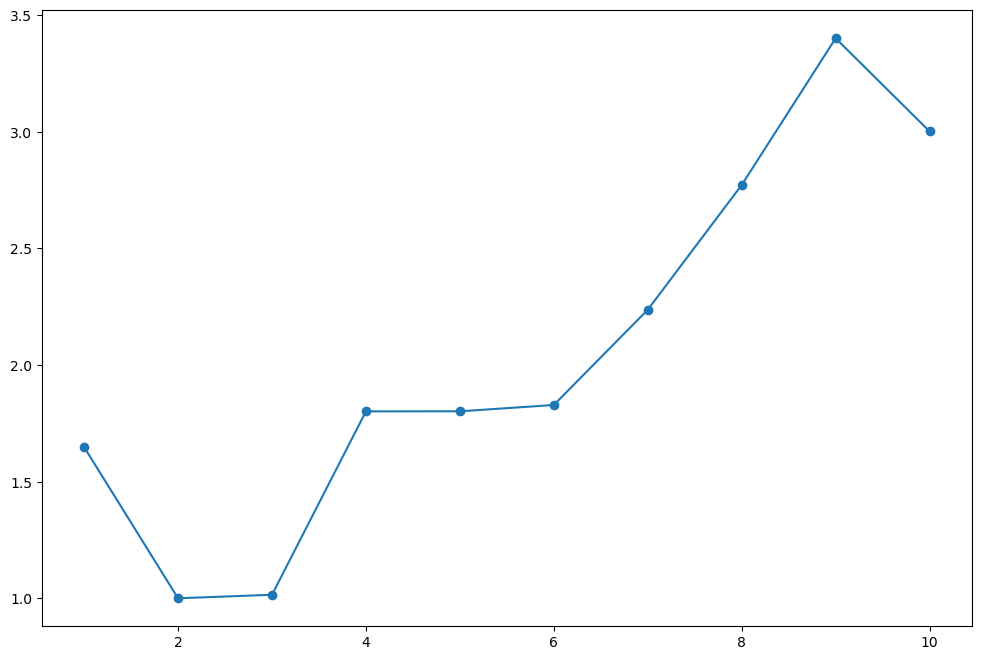

In [20]:
print(uncertainties)
plt.plot(complexities, uncertainties, '-o'); plt.show()

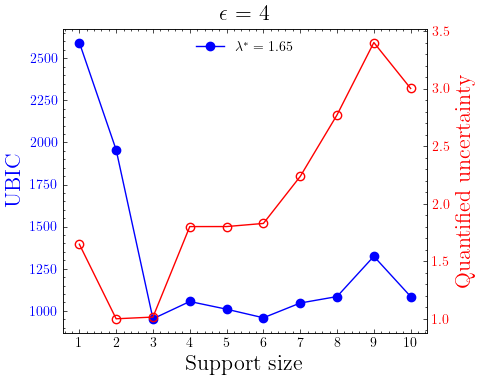

In [23]:
import getpass
import scienceplots
fs = 20
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(5, 4))

    color = 'blue'
    ax.set_xlabel('Support size', fontsize=fs)
    ax.set_ylabel('UBIC', color=color, fontsize=fs)
    ax.plot(complexities, ubic_plot, '-o', color=color, label='$\lambda^{*} = $' + ' ' + str(abs(round(lam_plot, 2))))
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xticks(complexities)
    ax.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)

    axp = ax.twinx()
    color = 'red'
    axp.set_ylabel('Quantified uncertainty', color=color, fontsize=fs)
    axp.plot(complexities, uncertainties, '-o', color=color, markerfacecolor="None")
    axp.tick_params(axis='y', labelcolor=color)
    
    ax.legend(fontsize=fs, loc='upper center')
    fig.tight_layout()
    plt.savefig(f"/Users/{getpass.getuser()}/Documents/latex/UBIC-ACML/figures/ad_ubic_noise{noise_lv}.pdf")
    plt.savefig(f"/Users/{getpass.getuser()}/Documents/latex/UBIC-ACML/figures/ad_ubic_noise{noise_lv}.png", dpi=300)
    plt.savefig(f"/Users/{getpass.getuser()}/Documents/latex/ML4PS/figures/ad_ubic_noise{noise_lv}.pdf")
    plt.savefig(f"/Users/{getpass.getuser()}/Documents/latex/ML4PS/figures/ad_ubic_noise{noise_lv}.png", dpi=300)
    plt.show()

In [21]:
# Computational time
# CPU times: user 9.71 s, sys: 11.5 ms, total: 9.72 s
# Wall time: 9.72 s

In [22]:
# propose
# significant testing (จำนวนกลุ่มตัวอย่างที่สุ่มออกมาเท่ากับ len(x) or len(t)) 
# + BIC in peridogram (& weak-form space for ordinary PDEs)
# note: epsilon = 1e-5
# metric learning not sure ... (optional)
# target PDEs Parametric Burgers, AD, KS + (Burgers&KS for ordinary PDEs)